In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Linear regression using the Normal Equation

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [3]:
X.shape, y.shape

((100, 1), (100, 1))

In [4]:
X[:3, :]

array([[0.74908024],
       [1.90142861],
       [1.46398788]])

In [5]:
y[:3]

array([[6.33428778],
       [9.40527849],
       [8.48372443]])

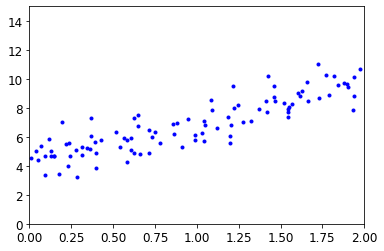

In [6]:
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance

In [8]:
X_b.shape

(100, 2)

In [9]:
X_b[:3]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788]])

The function that we below used to generate the data is $y = 4 + 3x_1 +$ *Gaussian noise*. Let’s see what the equation found:

In [10]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [11]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$ instead of $\theta_0 = 4.215$ and $\theta_1 = 2.770$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using 
$\hat\theta$:

In [12]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

In [13]:
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions:

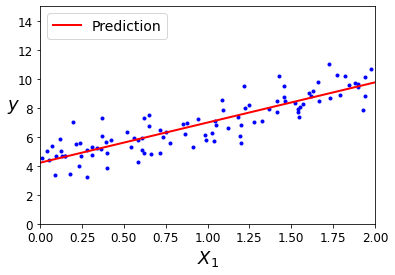

In [38]:
plt.plot(X, y, 'b.')
plt.plot(X_new, y_predict, 'r-', linewidth=2, label='Prediction')
plt.axis([0, 2, 0, 15])
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc='upper left', fontsize=14)
plt.show()

# Performing Linear Regression using Scikit-Learn

In [14]:
from sklearn.linear_model import LinearRegression

In [40]:
LinearRegression??

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=None,
)
Source:        
class LinearRegression(MultiOutputMixin, RegressorMixin, LinearModel):
    """
    Ordinary least squares Linear Regression.

    LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
    to minimize the residual sum of squares between the observed targets in
    the dataset, and the targets predicted by the linear approximation.

    Parameters
    ----------
    fit_intercept : bool, default=True
        Whether to calculate the intercept for this model. If set
        to False, no intercept will be used in calculations
        (i.e. data is expected to be centered).

    normalize : bool, default=False
        This parameter is ignored when ``fit_intercept`` is set to False.
        If True, the regressors X will be normalized before regression by
        subtracting the mean and dividing by the l2-norm.
        If you wish to s

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [42]:
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [43]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for “**least squares**”), which you could call directly:

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [17]:
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [18]:
residuals, rank, s

(array([80.6584564]), 2, array([14.37020392,  4.11961067]))

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [19]:
np.linalg.pinv(X_b).dot(y) # pseudoinverse of X_b

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **_Singular Value Decomposition (SVD)_** 

# Computational Complexity

The Normal Equation computes the inverse of $X^⊺ X$, which is an $(n + 1) × (n + 1)$ matrix (where $n$ is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

The SVD approach used by Scikit-Learn’s `LinearRegression` class is about $O(n^2)$. `If you double the number of features, you multiply the computation time by roughly 4.`

# **`WARNING`**

> **Both the Normal Equation and the SVD approach get very slow when the number of features grows large (e.g., 100,000). On the positive side, both are linear with regard to the number of instances in the training set (they are O(m)), so they handle large training sets efficiently, provided they can fit in memory.**

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), `predictions are very fast`: the computational complexity is linear with regard to both the number of instances you want to make predictions on and the number of features. In other words, making predictions on twice as many instances (or twice as many features) will take roughly twice as much time.

Now we will look at a very different way to train a Linear Regression model, which is better suited for cases where there are a large number of features or too many training instances to fit in memory.

# Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

An important parameter in Gradient Descent is the size of the steps, determined by the `learning rate hyperparameter`. <br>
If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. <br>
On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution

Finally, not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, making convergence to the minimum difficult. Below figure shows the two main challenges with Gradient Descent. If the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum. If it starts on the right, then it will take a very long time to cross the plateau. And if you stop too early, you will never reach the global minimum.

![Gradient Descent Pitfalls](images/training_linear_models/gradient_descent_pitfalls.png)

Fortunately, `the MSE cost function for a Linear Regression model happens to be a convex function`, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are `no local minima, just one global minimum`. It is also a continuous function with a slope that never changes abruptly. These two facts have a great consequence: `Gradient Descent is guaranteed to approach arbitrarily close the global minimum` (if you wait long enough and if the learning rate is not too high).

**`In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Below Figure shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).`**

![Gradient Descent with (left) and without (right) feature scaling](images/training_linear_models/gradient_descent_feature_scaling.png)

As you can see, on the left the Gradient Descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

## **`WARNING`**

> `When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.`

# Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter $θ_j$. In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit. This is called a `partial derivative`. <br>
It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions).

# WARNING

> Notice that in a formula that involves calculations over the full training set X, at each Gradient Descent step is called `Batch Gradient Descent`: it uses the whole batch of training data at every step (actually, Full Gradient Descent would probably be a better name). <br>
As a result it is terribly slow on very large training sets (but we will see much faster Gradient Descent algorithms shortly). However, `Gradient Descent scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation or SVD decomposition.`

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $∇_θ MSE(θ)$ from $θ$. This is where the learning rate $η$ comes into play: `multiply the gradient vector by` $η$ `to determine the size of the downhill step` 

$$θ^{(next step)} = θ - η∇_θMSE(θ)$$

Let’s look at a quick implementation of this algorithm:

In [16]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

In [21]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta*gradients

That wasn’t too hard! Let’s look at the resulting theta:

In [22]:
theta

array([[4.21509616],
       [2.77011339]])

In [23]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

Hey, that’s exactly what the Normal Equation found! Gradient Descent worked perfectly. But what if you had used a different learning rate $\eta$? Below Figures show the first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point).

In [24]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, 'b.')
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if iteration > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path_bgd.append(theta)
        
    plt.xlabel("$X_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    

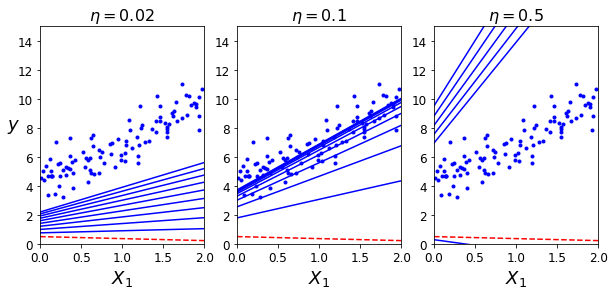

In [25]:
np.random.seed(42)

theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
plt.show()

In [26]:
np.array(theta_path_bgd).shape

(1000, 2, 1)

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. In the middle, the learning rate looks pretty good: in just a few iterations, it has already converged to the solution. On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step

**`To find a good learning rate, you can use grid search`** (see Chapter 2). **`However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.`**

You may wonder `how to set the number of iterations`. <br>
If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. <br>
**_A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number `ϵ (called the tolerance)`—because this happens when Gradient Descent has (almost) reached the minimum._**

## CONVERGENCE RATE

> When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while: it can take $O(1/ϵ)$ iterations to reach the optimum within a range of ϵ, depending on the shape of the cost function. `If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer.`

# Stochastic Gradient Descent

**The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large.** <br>
At the opposite extreme, **Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance.** <br>
Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (`Stochastic GD can be implemented as an out-of-core algorithm`; see Chapter 1).

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: `instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down (see below Figure). So once the algorithm stops, the final parameter values are good, but not optimal.`

![With Stochastic Gradient Descent, each training step is much faster but also much more stochastic than when using Batch Gradient Descent](images/training_linear_models/stochastic_gradient_descent_learning.png)

When the cost function is very irregular (as in above Figure of many pitfalls in cost function), this can actually help the algorithm jump out of local minima, so `Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does.`

Therefore, randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum. <br>
* One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is akin to `simulated annealing`, an algorithm inspired from the process in metallurgy of annealing, where molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the `learning schedule`. 
* If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.

Let's implement Stochastic Gradient Descent using a simple learning schedule

In [27]:
m, X.shape, y.shape, X_b.shape

(100, (100, 1), (100, 1), (100, 2))

In [28]:
X_b[27:28], X_b[27]

(array([[1.        , 1.02846888]]), array([1.        , 1.02846888]))

In [29]:
y[27:28], y[27, :]

(array([[6.28312936]]), array([6.28312936]))

In [30]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradient

By convention we iterate by rounds of $m$ iterations; `each round is called an epoch`. While the Batch Gradient Descent code iterated 1,000 times through the whole training set, this code goes through the training set only 50 times and reaches a pretty good solution:

In [31]:
theta

array([[4.20742938],
       [2.74264448]])

In [32]:
np.random.seed(42)

theta_path_sgd = []

def plot_sgd(theta, n_epochs=20):
    m = len(X_b)
    plt.plot(X, y, 'b.')
    for epoch in range(n_epochs):
        for i in range(m):
            if epoch == 0 and i < 20:
                y_predict = X_new_b.dot(theta)
                style = 'b-' if i > 0 else 'r--'
                plt.plot(X_new, y_predict, style)
            random_index = np.random.randint(m)
            xi = X_b[random_index:random_index + 1]
            yi = y[random_index:random_index + 1]
            gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradient
            theta_path_sgd.append(theta)
            
    plt.xlabel('$X_1$', fontsize=18)
    plt.ylabel('$y$', rotation=0, fontsize=18)
    plt.axis([0, 2, 0, 15])

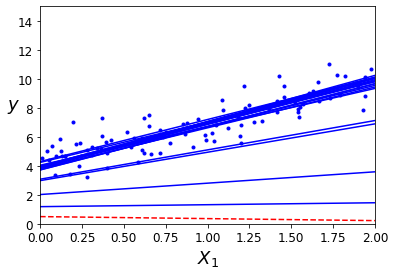

In [33]:
plot_sgd(np.random.randn(2, 1))

In [34]:
np.array(theta_path_sgd).shape

(2000, 2, 1)

Note that since instances are picked randomly, some instances may be picked several times per epoch, while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach generally converges more slowly.

## **_`WARNING`_**

> **_`When using Stochastic Gradient Descent, the training instances must be independent and identically distributed (IID) to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training (e.g., pick each instance randomly, or shuffle the training set at the beginning of each epoch). If you do not shuffle the instances—for example, if the instances are sorted by label—then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.`_**

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class, which defaults to optimizing the squared error cost function. The following code runs for maximum 1,000 epochs or until the loss drops by less than 0.001 during one epoch (max_iter=1000, tol=1e-3). It starts with a learning rate of 0.1 (eta0=0.1), using the default learning schedule (different from the preceding one). Lastly, it does not use any regularization (penalty=None; more details on this shortly):

In [35]:
from sklearn.linear_model import SGDRegressor

In [42]:
SGDRegressor??

Init signature:
SGDRegressor(
    loss='squared_loss',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    random_state=None,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    warm_start=False,
    average=False,
)
Source:        
class SGDRegressor(BaseSGDRegressor):
    """Linear model fitted by minimizing a regularized empirical loss with SGD

    SGD stands for Stochastic Gradient Descent: the gradient of the loss is
    estimated each sample at a time and the model is updated along the way with
    a decreasing strength schedule (aka learning rate).

    The regularizer is a penalty added to the loss function that shrinks model
    parameters towards the zero vector using either the squared euclidean norm
    L2 or the absolute norm L1 or a combination of both (Ela

In [36]:
y[:3], y[:3].ravel()

(array([[6.33428778],
        [9.40527849],
        [8.48372443]]),
 array([6.33428778, 9.40527849, 8.48372443]))

In [37]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

Once again, you find a solution quite close to the one returned by the Normal Equation:

In [38]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

# Mini-batch Gradient Descent

The last Gradient Descent algorithm we will look at is called `Mini-batch Gradient Descent`. It is simple to understand once you know Batch and Stochastic Gradient Descent: at each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called `mini-batches`. `The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.`

The algorithm’s progress in parameter space is less erratic than with Stochastic GD, especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking around a bit closer to the minimum than Stochastic GD—but it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression). Figure 4-11 shows the paths taken by the three Gradient Descent algorithms in parameter space during training. They all end up near the minimum, but Batch GD’s path actually stops at the minimum, while both Stochastic GD and Mini-batch GD continue to walk around. However, don’t forget that Batch GD takes a lot of time to take each step, and Stochastic GD and Mini-batch GD would also reach the minimum if you used a good learning schedule.

In [39]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradient = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradient
        theta_path_mgd.append(theta)
    

In [40]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [41]:
np.array(theta_path_mgd).shape

(250, 2, 1)

In [42]:
theta_path_bgd = np.array(theta_path_bgd) 
theta_path_sgd = np.array(theta_path_sgd) 
theta_path_mgd = np.array(theta_path_mgd) 

In [43]:
theta_path_bgd.shape, theta_path_sgd.shape, theta_path_mgd.shape 

((1000, 2, 1), (2000, 2, 1), (250, 2, 1))

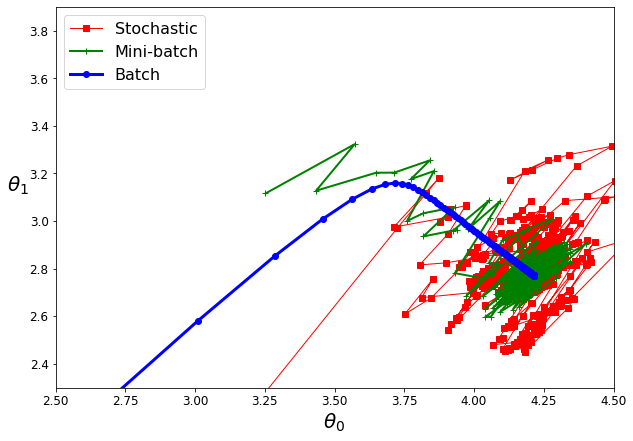

In [44]:
plt.figure(figsize=(10, 7)) 
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
# save_fig("gradient_descent_paths_plot")
plt.show()

Let’s compare the algorithms we’ve discussed so far for Linear Regression6 (recall that $m$ is the number of training instances and $n$ is the number of features); see Table 4-1.

![Comparison of algorithms for Linear Regression](images/training_linear_models/comparison_of_algorithms_for_linear_regression.png)

# NOTE

> **`There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly the same way.`**

# Polynomial Regression

`What if your data is more complex than a straight line?` Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called `Polynomial Regression`.

Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation7 (plus some noise; see in below figure/graph)

In [60]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [61]:
X.shape, y.shape

((100, 1), (100, 1))

In [62]:
X[:3], y[:3]

(array([[-0.75275929],
        [ 2.70428584],
        [ 1.39196365]]),
 array([[1.61761105],
        [8.06185944],
        [4.45250583]]))

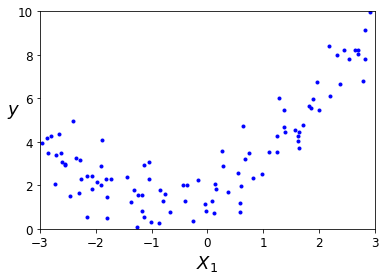

In [63]:
# Plotting nonlinear and noisy dataset

plt.plot(X, y, 'b.')
plt.axis([-3, 3, 0, 10])
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s `PolynomialFeatures` class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [41]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
PolynomialFeatures??

Init signature:
PolynomialFeatures(
    degree=2,
    *,
    interaction_only=False,
    include_bias=True,
    order='C',
)
Source:        
class PolynomialFeatures(TransformerMixin, BaseEstimator):
    """Generate polynomial and interaction features.

    Generate a new feature matrix consisting of all polynomial combinations
    of the features with degree less than or equal to the specified degree.
    For example, if an input sample is two dimensional and of the form
    [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

    Parameters
    ----------
    degree : integer
        The degree of the polynomial features. Default = 2.

    interaction_only : boolean, default = False
        If true, only interaction features are produced: features that are
        products of at most ``degree`` *distinct* input features (so not
        ``x[1] ** 2``, ``x[0] * x[2] ** 3``, etc.).

    include_bias : boolean
        If True (default), then include a bias column, the f

In [65]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [66]:
print(X[0], X_poly[0], sep='\n\n')

[-0.75275929]

[-0.75275929  0.56664654]


In [67]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [68]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [69]:
print(X.shape, y.shape, X_poly.shape, X_new.shape, X_new_poly.shape, y_new.shape, sep='\n')
# print(X.shape, y.shape, X_poly.shape, sep='\n')

(100, 1)
(100, 1)
(100, 2)
(100, 1)
(100, 2)
(100, 1)


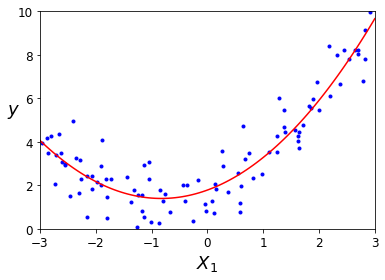

In [70]:
np.random.seed(42)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-')
plt.axis([-3, 3, 0, 10])
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.show()

Not bad: the model estimates
$y = 0.56x_1^2 + 0.93x_1 + 1.78$
when in fact the original function was
$y
=
0.5
x_
1^
2
+
1.0
x_
1
+
2.0
+
Gaussian noise
.$

**Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features $a$ and $b$, `PolynomialFeatures` with $degree=3$ would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2b$, and $ab^2$.**

# WARNING

> `PolynomialFeatures`($degree=d$) transforms an array containing $n$ features into an array containing 
$\frac{(
n
+
d
)
!}{
d
!
n
!}$
features, where $n!$ is the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. **`Beware of the combinatorial explosion of the number of features!`**

# Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training data much better than with plain Linear Regression. For example, below Figure applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (second-degree polynomial). Notice `how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.`

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

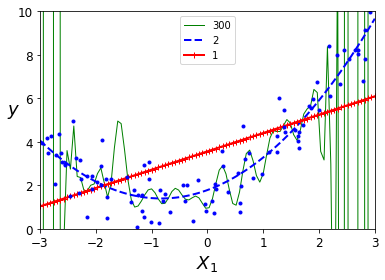

In [72]:
for style, width, degree in (('g-', 1, 300), ('b--', 2, 2), ('r-+', 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree)
    std_scalar = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ('poly_features', polybig_features),
        ('std_scalar', std_scalar),
        ('lin_reg', lin_reg),
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, linewidth=width, label=str(degree))
    
plt.plot(X, y, 'b.')
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
# plt.legend(loc='upper left')
plt.legend()
plt.show()

This high-degree Polynomial Regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. <br>
**`But in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?`**

**`In Chapter 2 you used cross-validation to get an estimate of a model’s generalization performance. If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.`**

**`Another way to tell is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:`**

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [75]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend()
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    

Let’s look at the learning curves of the plain Linear Regression model (a straight line; see Figure below):

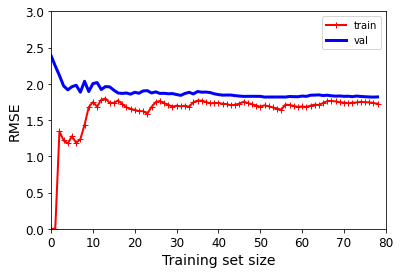

In [79]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

`This model that’s underfitting deserves` a bit of explanation. First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.
<br>

**`These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.`**

# TIP

> **`If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with better features.`**

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data (Figure below):

In [38]:
from sklearn.pipeline import Pipeline

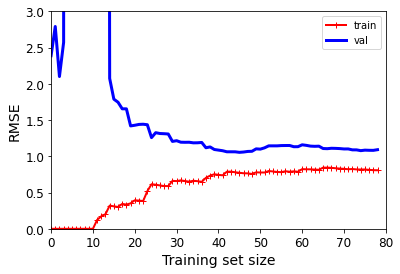

In [82]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

These learning curves look a bit like the previous ones, but there are two important differences:
* The error on the training data is much lower than with the Linear Regression model.
* `There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an` **_`overfitting model.`_** `If you used a much larger training set, however, the two curves would continue to get closer.`

# TIP

> **`One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.`**

# THE BIAS/VARIANCE TRADE-OFF

_An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:_

### _Bias_

> This part of the `generalization error is due to wrong assumptions`, such as assuming that the data is linear when it is actually quadratic. `A high-bias model is most likely to underfit the training data.`

### _Variance_

> This part is due to the `model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.`

### _Irreducible error_

> This part is `due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).`

**_`Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.`_**

# Regularized Linear Models

As we saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at Ridge Regression, Lasso Regression, and Elastic Net, which implement three different ways to constrain the weights.

## Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $$\alpha\sum_{i = 1}^n \theta_i^2$$
is added  to cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. `Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model's performance.`

# Note

> It is quite common for the cost function used during training to be different from the performance measure used for testing. Apart from regularization, **another reason they might be different is that a good trianing cost function should have optimizaiton-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective.** `For example, classifiers are often trained using a cost function such as the log loss (discussed in a moment) but evaluated using precision/recall.`

The hyperparameter **$\alpha$ controls how much you want to regularize the model.** If $\alpha = 0$, then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. Equation below presents the Ridge Regression cost function.

Equation: Ridge Regression cost function
$$J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i = 1}^{n}\theta_i^2$$

Note that the bias term $\theta_0$ is not regularized (the sum starts at $i = 1$, not $0$). If we define $\mathbf{w}$ as the vector of feature weights ($\theta_1$ to $\theta_n$), then the regularization term is equal to $\frac{1}{2}(\parallel \mathbf{w} \parallel_2)^2$, where $\parallel \mathbf{w} \parallel_2$ represents the $l_2$ norm of the weight vector. For Gradient Descent, just add $\alpha\mathbf{w}$ to the MSE gradient vector

# Warning

> **It is important to scale the data** (e.g., using a `StandardScaler`) before performing Ridge Regression, as it is **sensitive to the scare of the input features**. This is true of most regularized models.

Figure below shows several Ridge models trained on some linear data using different $\alpha$ values. <br>
* On the left, plain Ridge models are used, leading to linear predictions. <br>
* On the right, the data is first expanded using `PolynomialFeatures(degree=10)`, then it is scaled using a `StandardScaler`, and finally the Ridge models are applied to the resulting features: this is Polynomial Regression with Ridge regularization. <br>

Note how increasing $\alpha$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias.

In [33]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [34]:
X.shape, y.shape, X_new.shape

((20, 1), (20, 1), (100, 1))

In [22]:
from sklearn.linear_model import Ridge

In [23]:
Ridge??

Init signature:
Ridge(
    alpha=1.0,
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    max_iter=None,
    tol=0.001,
    solver='auto',
    random_state=None,
)
Source:        
class Ridge(MultiOutputMixin, RegressorMixin, _BaseRidge):
    """Linear least squares with l2 regularization.

    Minimizes the objective function::

    ||y - Xw||^2_2 + alpha * ||w||^2_2

    This model solves a regression model where the loss function is
    the linear least squares function and regularization is given by
    the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
    This estimator has built-in support for multi-variate regression
    (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

    Read more in the :ref:`User Guide <ridge_regression>`.

    Parameters
    ----------
    alpha : {float, ndarray of shape (n_targets,)}, default=1.0
        Regularization strength; must be a positive float. Regularization
        improves the condition

In [35]:
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [36]:
ridge_reg.intercept_, ridge_reg.coef_

(array([1.00650911]), array([[0.36280369]]))

In [37]:
ridge_reg = Ridge(alpha=1, solver='sag', random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

In [ ]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha=alpha, **model_kwargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidht=lw, label='$\alpha = {}$'.format(alpha))
    plt.plt(X, y, 'b.')